**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np
from torchvision.utils import save_image

In [2]:
!pip install -U albumentations
import albumentations as A
import cv2


import albumentations as A
from albumentations.pytorch import ToTensorV2

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [3]:
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                      ])

In [4]:
train_transforms_a = A.Compose([
                                       A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
                                       A.Sequential([
                                         A.PadIfNeeded(
                                             min_height=36,
                                             min_width=36,
                                             border_mode=cv2.BORDER_CONSTANT,
                                             value=(0.4914,0.4822,0.4465)
                                         ),
                                         A.RandomCrop(
                                             height=32,
                                             width=32
                                         )
                                       ], p = 0.5),
                                       #A.Cutout(num_holes=1,max_h_size=16,max_w_size=16,fill_value=(0.4914,0.4822,0.4465))
                                       A.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value=None),
                                       ToTensorV2()
                                       ])

In [5]:
import cv2
import torchvision

##copied from albumentations.io
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class data_albumentations(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label



In [6]:
#train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
train = data_albumentations(train=True,  download=True, transform=train_transforms_a)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


In [8]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [9]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
#chsum = 0
##pbar = tqdm(train_loader_nonorm)

#for index, (data,target) in enumerate(train_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(train_nonorm) * 32 *32)
#
#chsum = None
#for index, (data,target) in enumerate(train_loader_nonorm):
#  if index == 0:
#   print(data.min(),data.max())
#   chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
#print("Traindata Mean",mean)
#print("Traindata std dev",std)

#chsum = 0

#for index, (data,target) in enumerate(test_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(test_nonorm) * 32 *32)

#chsum = None
#for index, (data,target) in enumerate(test_loader_nonorm):
#  if index == 0:
#    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
#print("Test data Mean",mean)
#print("Test data std dev",std)

ship


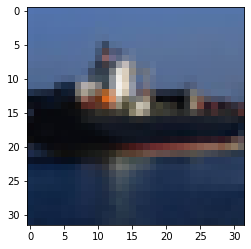

In [11]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**####Batch Normalization + L1 LOSS**

In [12]:
dropout_perc = 0.05

class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
            #output size = 32 ; receptive field = 3x3
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
            #output size = 32 ; receptive field = 5x5
        ) 
        
       #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        )  #output size = 32 ; receptive field = 5x5

        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation =1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #Use dilated kernels instead of Max pooling / stride =2 conv
        self.pool1_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32 , kernel_size=(3, 3), dilation=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64 ,kernel_size=(3, 3), dilation=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        ) ; #output size = 28 ; receptive field = 13x13
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, dilation = 2 ,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) ; #output size = 26 ; receptive field = 17x17
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, dilation =2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) ; #output size = 24 ; receptive field = 21x21

       
        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        )
             

        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        self.pool2_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32, kernel_size=(3, 3), padding=1, dilation =2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, dilation =2,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0,bias=False)
        ); #output size = 20 ; receptive field = 29x29

        #BLOCK C3

     
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, dilation =2,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        );#output size = 18 ; receptive field = 33x33
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, dilation=2 , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        );#output size = 16 ; receptive field = 37x37

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.pool3_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups=32 , kernel_size=(3, 3), padding=1, dilation = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        );#output size = 14 ; receptive field = 41x41
        #BLOCK C4
        
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, dilation=2 , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) ;#output size = 12 ; receptive field = 45x45
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128 , kernel_size=(3, 3), padding=1, dilation =2,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        );#output size = 10 ; receptive field = 49x49

        self.convblock25 = nn.Sequential(
            nn.Conv2d(in_channels=256, groups = 256, out_channels=512, kernel_size=(3, 3), padding=1, dilation=2, bias=False)
        );#output size = 8 ; receptive field = 53x53

                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock13 = nn.Sequential(
            nn.Linear(512,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock4(x)
        
        #x = self.pool1(x)
        x = self.pool1_dilation(x)
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        #x = self.pool2(x)
        x = self.pool2_dilation(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        #x = self.pool3(x)
        x = self.pool3_dilation(x)
        
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock25(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock13(x)
   
        return F.log_softmax(x, dim=-1)

In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
       
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            self._make_layer(block, 64, num_blocks[0], stride=1),
            self._make_layer(block, 128, num_blocks[1], stride=2),
            self._make_layer(block, 256, num_blocks[2], stride=2),
            self._make_layer(block, 512, num_blocks[3], stride=1)
        )
        self.linear = nn.Linear(512*block.expansion, num_classes)

        self.gradient = None
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        print('a1')
        out = self.features(x)
        print('a6')
        return out
    
    def forward(self, x):
      
        out = self.features(x)
        
        if out.requires_grad:
          out.register_hook(self.activations_hook)

        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [15]:
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

reached resnet block init
reached basicl block init
reached basicl block init
reached basicl block init
reached basicl block init
reached basicl block init
reached basicl block init
reached basicl block init
reached basicl block init
resnet block end
f1
f2
f3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
        BasicBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1,

####LayerNorm Normalization + L1 LOSS

**`####Group normalization network + L1 LOSS`**

In [16]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_pred_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    #print(loss)
    #print(loss.type)
    #print(loss.shape)
    #break
    loss.backward()
    
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []
    test_pred_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred,target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                test_pred_target.append(pred[i])
                #print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target;    

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [ ]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = ResNet18().to(device)
    #test_10_images, test_10_images_target , test_10_pred_target
    run_train_test(model,EPOCHS,input_model_type)
    #return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  #summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=20, gamma=0.7)

  for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
         
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    #test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  test_10_pred_target = []
  for i in range(0,10):
    test_10_pred_target.append(test_pred_target[i])
  #print(test_10_images_target)

  print('Actual Labels')
  print(' '.join('%5s' % classes[test_10_images_target[j]] for j in range(0,10)))
  print('Predicted Labels')
  print(' '.join('%5s' % classes[test_10_pred_target[j]] for j in range(0,10)))

  test_10_images_unnorm = []
  for img in test_10_images:
    img = img.cpu()
    img = img.numpy()
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.2435 + 0.4822
    img[2] = img[2] * 0.2616 + 0.4465

    img = torch.from_numpy(img)
    test_10_images_unnorm.append(img)
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

  #return test_10_images, test_10_images_target , test_10_pred_target;

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


In [17]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=20, gamma=0.7)
#model = ResNet18().to(device)
for epoch in range(1):
    #print("EPOCH:", epoch)
         
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0, lr 0.02
f1
f2
f3


Loss=13.233884811401367 Batch_id=1 Accuracy=14.84:   1%|          | 2/391 [00:00<01:52,  3.46it/s]

f1
f2
f3
f1
f2
f3


Loss=13.192583084106445 Batch_id=3 Accuracy=14.45:   1%|          | 4/391 [00:00<01:26,  4.47it/s]

f1
f2
f3
f1
f2
f3


Loss=12.953948974609375 Batch_id=5 Accuracy=16.28:   2%|▏         | 6/391 [00:01<01:13,  5.21it/s]

f1
f2
f3
f1
f2
f3


Loss=13.050537109375 Batch_id=7 Accuracy=17.87:   2%|▏         | 8/391 [00:01<01:07,  5.65it/s]

f1
f2
f3
f1
f2
f3


Loss=13.027795791625977 Batch_id=9 Accuracy=18.44:   3%|▎         | 10/391 [00:01<01:04,  5.93it/s]

f1
f2
f3
f1
f2
f3


Loss=12.970621109008789 Batch_id=11 Accuracy=19.01:   3%|▎         | 12/391 [00:02<01:02,  6.04it/s]

f1
f2
f3
f1
f2
f3


Loss=12.984630584716797 Batch_id=13 Accuracy=19.64:   4%|▎         | 14/391 [00:02<01:01,  6.11it/s]

f1
f2
f3
f1
f2
f3


Loss=12.678224563598633 Batch_id=15 Accuracy=20.51:   4%|▍         | 16/391 [00:02<01:00,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=12.6892728805542 Batch_id=17 Accuracy=21.05:   5%|▍         | 18/391 [00:03<01:00,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=12.87964916229248 Batch_id=19 Accuracy=21.68:   5%|▌         | 20/391 [00:03<00:59,  6.24it/s]

f1
f2
f3
f1
f2
f3


Loss=12.6185941696167 Batch_id=21 Accuracy=22.12:   6%|▌         | 22/391 [00:03<00:59,  6.18it/s]

f1
f2
f3
f1
f2
f3


Loss=12.849178314208984 Batch_id=23 Accuracy=22.75:   6%|▌         | 24/391 [00:04<00:59,  6.17it/s]

f1
f2
f3
f1
f2
f3


Loss=12.568285942077637 Batch_id=25 Accuracy=22.93:   7%|▋         | 26/391 [00:04<00:58,  6.21it/s]

f1
f2
f3
f1
f2
f3


Loss=12.622828483581543 Batch_id=27 Accuracy=23.13:   7%|▋         | 28/391 [00:04<00:59,  6.12it/s]

f1
f2
f3
f1
f2
f3


Loss=12.49632453918457 Batch_id=29 Accuracy=23.46:   8%|▊         | 30/391 [00:05<00:58,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=12.438546180725098 Batch_id=31 Accuracy=23.61:   8%|▊         | 32/391 [00:05<00:58,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=12.309377670288086 Batch_id=33 Accuracy=24.03:   9%|▊         | 34/391 [00:05<00:57,  6.19it/s]

f1
f2
f3
f1
f2
f3


Loss=12.188421249389648 Batch_id=35 Accuracy=24.50:   9%|▉         | 36/391 [00:06<00:57,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=12.25764274597168 Batch_id=37 Accuracy=24.57:  10%|▉         | 38/391 [00:06<00:56,  6.22it/s]

f1
f2
f3
f1
f2
f3


Loss=12.175127029418945 Batch_id=39 Accuracy=25.00:  10%|█         | 40/391 [00:06<00:56,  6.20it/s]

f1
f2
f3
f1
f2
f3


Loss=12.372248649597168 Batch_id=41 Accuracy=25.20:  11%|█         | 42/391 [00:06<00:56,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=12.151323318481445 Batch_id=43 Accuracy=25.46:  11%|█▏        | 44/391 [00:07<00:56,  6.19it/s]

f1
f2
f3
f1
f2
f3


Loss=11.976625442504883 Batch_id=45 Accuracy=25.95:  12%|█▏        | 46/391 [00:07<00:55,  6.17it/s]

f1
f2
f3
f1
f2
f3


Loss=11.994270324707031 Batch_id=47 Accuracy=26.16:  12%|█▏        | 48/391 [00:07<00:55,  6.13it/s]

f1
f2
f3
f1
f2
f3


Loss=12.012144088745117 Batch_id=49 Accuracy=26.44:  13%|█▎        | 50/391 [00:08<00:55,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=11.9771728515625 Batch_id=51 Accuracy=26.71:  13%|█▎        | 52/391 [00:08<00:55,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=11.799922943115234 Batch_id=53 Accuracy=26.95:  14%|█▍        | 54/391 [00:08<00:54,  6.13it/s]

f1
f2
f3
f1
f2
f3


Loss=11.728384017944336 Batch_id=55 Accuracy=27.53:  14%|█▍        | 56/391 [00:09<00:54,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=11.826644897460938 Batch_id=57 Accuracy=27.69:  15%|█▍        | 58/391 [00:09<00:54,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=11.722400665283203 Batch_id=59 Accuracy=27.90:  15%|█▌        | 60/391 [00:09<00:54,  6.12it/s]

f1
f2
f3
f1
f2
f3


Loss=11.82480525970459 Batch_id=61 Accuracy=28.02:  16%|█▌        | 62/391 [00:10<00:53,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=11.515460968017578 Batch_id=63 Accuracy=28.42:  16%|█▋        | 64/391 [00:10<00:53,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=11.48438549041748 Batch_id=65 Accuracy=28.63:  17%|█▋        | 66/391 [00:10<00:52,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=11.505270004272461 Batch_id=67 Accuracy=28.81:  17%|█▋        | 68/391 [00:11<00:52,  6.17it/s]

f1
f2
f3
f1
f2
f3


Loss=11.55050277709961 Batch_id=69 Accuracy=29.14:  18%|█▊        | 70/391 [00:11<00:52,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=11.40540885925293 Batch_id=71 Accuracy=29.25:  18%|█▊        | 72/391 [00:11<00:51,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=11.273416519165039 Batch_id=73 Accuracy=29.57:  19%|█▉        | 74/391 [00:12<00:51,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=11.250328063964844 Batch_id=75 Accuracy=29.73:  19%|█▉        | 76/391 [00:12<00:51,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=11.293224334716797 Batch_id=77 Accuracy=29.78:  20%|█▉        | 78/391 [00:12<00:50,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=11.22916316986084 Batch_id=79 Accuracy=29.89:  20%|██        | 80/391 [00:13<00:50,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=11.22462272644043 Batch_id=81 Accuracy=30.14:  21%|██        | 82/391 [00:13<00:50,  6.11it/s]

f1
f2
f3
f1
f2
f3


Loss=11.11874771118164 Batch_id=83 Accuracy=30.22:  21%|██▏       | 84/391 [00:13<00:50,  6.08it/s]

f1
f2
f3
f1
f2
f3


Loss=11.083547592163086 Batch_id=85 Accuracy=30.41:  22%|██▏       | 86/391 [00:14<00:50,  6.08it/s]

f1
f2
f3
f1
f2
f3


Loss=11.040316581726074 Batch_id=87 Accuracy=30.53:  23%|██▎       | 88/391 [00:14<00:50,  6.06it/s]

f1
f2
f3
f1
f2
f3


Loss=11.082592964172363 Batch_id=89 Accuracy=30.63:  23%|██▎       | 90/391 [00:14<00:49,  6.10it/s]

f1
f2
f3
f1
f2
f3


Loss=10.895769119262695 Batch_id=91 Accuracy=30.76:  24%|██▎       | 92/391 [00:15<00:48,  6.13it/s]

f1
f2
f3
f1
f2
f3


Loss=10.881363868713379 Batch_id=93 Accuracy=30.93:  24%|██▍       | 94/391 [00:15<00:48,  6.13it/s]

f1
f2
f3
f1
f2
f3


Loss=10.777015686035156 Batch_id=95 Accuracy=31.09:  25%|██▍       | 96/391 [00:15<00:48,  6.13it/s]

f1
f2
f3
f1
f2
f3


Loss=10.715633392333984 Batch_id=97 Accuracy=31.24:  25%|██▌       | 98/391 [00:16<00:47,  6.17it/s]

f1
f2
f3
f1
f2
f3


Loss=10.726030349731445 Batch_id=99 Accuracy=31.37:  26%|██▌       | 100/391 [00:16<00:47,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=10.797079086303711 Batch_id=101 Accuracy=31.47:  26%|██▌       | 102/391 [00:16<00:47,  6.11it/s]

f1
f2
f3
f1
f2
f3


Loss=10.7902193069458 Batch_id=103 Accuracy=31.55:  27%|██▋       | 104/391 [00:17<00:47,  6.09it/s]

f1
f2
f3
f1
f2
f3


Loss=10.63715934753418 Batch_id=105 Accuracy=31.63:  27%|██▋       | 106/391 [00:17<00:46,  6.06it/s]

f1
f2
f3
f1
f2
f3


Loss=10.420676231384277 Batch_id=107 Accuracy=31.81:  28%|██▊       | 108/391 [00:17<00:46,  6.06it/s]

f1
f2
f3
f1
f2
f3


Loss=10.536419868469238 Batch_id=109 Accuracy=32.00:  28%|██▊       | 110/391 [00:18<00:46,  6.05it/s]

f1
f2
f3
f1
f2
f3


Loss=10.54835033416748 Batch_id=111 Accuracy=32.09:  29%|██▊       | 112/391 [00:18<00:45,  6.08it/s]

f1
f2
f3
f1
f2
f3


Loss=10.470354080200195 Batch_id=113 Accuracy=32.33:  29%|██▉       | 114/391 [00:18<00:45,  6.09it/s]

f1
f2
f3
f1
f2
f3


Loss=10.467411041259766 Batch_id=115 Accuracy=32.42:  30%|██▉       | 116/391 [00:19<00:45,  6.08it/s]

f1
f2
f3
f1
f2
f3


Loss=10.36617374420166 Batch_id=117 Accuracy=32.53:  30%|███       | 118/391 [00:19<00:44,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=10.382798194885254 Batch_id=119 Accuracy=32.63:  31%|███       | 120/391 [00:19<00:44,  6.10it/s]

f1
f2
f3
f1
f2
f3


Loss=10.169904708862305 Batch_id=121 Accuracy=32.75:  31%|███       | 122/391 [00:20<00:43,  6.18it/s]

f1
f2
f3
f1
f2
f3


Loss=10.54568099975586 Batch_id=123 Accuracy=32.78:  32%|███▏      | 124/391 [00:20<00:42,  6.21it/s]

f1
f2
f3
f1
f2
f3


Loss=10.127427101135254 Batch_id=125 Accuracy=32.90:  32%|███▏      | 126/391 [00:20<00:42,  6.17it/s]

f1
f2
f3
f1
f2
f3


Loss=10.099396705627441 Batch_id=127 Accuracy=33.06:  33%|███▎      | 128/391 [00:21<00:42,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=10.042837142944336 Batch_id=129 Accuracy=33.28:  33%|███▎      | 130/391 [00:21<00:42,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=10.092300415039062 Batch_id=131 Accuracy=33.43:  34%|███▍      | 132/391 [00:21<00:42,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=9.912205696105957 Batch_id=133 Accuracy=33.63:  34%|███▍      | 134/391 [00:21<00:41,  6.20it/s]

f1
f2
f3
f1
f2
f3


Loss=10.098808288574219 Batch_id=135 Accuracy=33.73:  35%|███▍      | 136/391 [00:22<00:41,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=10.009679794311523 Batch_id=137 Accuracy=33.87:  35%|███▌      | 138/391 [00:22<00:41,  6.12it/s]

f1
f2
f3
f1
f2
f3


Loss=9.899659156799316 Batch_id=139 Accuracy=34.00:  36%|███▌      | 140/391 [00:22<00:40,  6.17it/s]

f1
f2
f3
f1
f2
f3


Loss=9.892531394958496 Batch_id=141 Accuracy=34.13:  36%|███▋      | 142/391 [00:23<00:40,  6.11it/s]

f1
f2
f3
f1
f2
f3


Loss=9.922921180725098 Batch_id=143 Accuracy=34.23:  37%|███▋      | 144/391 [00:23<00:40,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=9.969935417175293 Batch_id=145 Accuracy=34.33:  37%|███▋      | 146/391 [00:23<00:39,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=9.792357444763184 Batch_id=147 Accuracy=34.42:  38%|███▊      | 148/391 [00:24<00:39,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=9.676578521728516 Batch_id=149 Accuracy=34.51:  38%|███▊      | 150/391 [00:24<00:39,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=9.764820098876953 Batch_id=151 Accuracy=34.60:  39%|███▉      | 152/391 [00:24<00:38,  6.18it/s]

f1
f2
f3
f1
f2
f3


Loss=9.795355796813965 Batch_id=153 Accuracy=34.68:  39%|███▉      | 154/391 [00:25<00:38,  6.17it/s]

f1
f2
f3
f1
f2
f3


Loss=9.63161849975586 Batch_id=155 Accuracy=34.74:  40%|███▉      | 156/391 [00:25<00:38,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=9.509669303894043 Batch_id=157 Accuracy=34.88:  40%|████      | 158/391 [00:25<00:38,  6.04it/s]

f1
f2
f3
f1
f2
f3


Loss=9.578264236450195 Batch_id=159 Accuracy=34.95:  41%|████      | 160/391 [00:26<00:38,  6.04it/s]

f1
f2
f3
f1
f2
f3


Loss=9.5582275390625 Batch_id=161 Accuracy=35.08:  41%|████▏     | 162/391 [00:26<00:37,  6.05it/s]

f1
f2
f3
f1
f2
f3


Loss=9.354391098022461 Batch_id=163 Accuracy=35.18:  42%|████▏     | 164/391 [00:26<00:37,  6.12it/s]

f1
f2
f3
f1
f2
f3


Loss=9.514875411987305 Batch_id=165 Accuracy=35.25:  42%|████▏     | 166/391 [00:27<00:36,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=9.33297348022461 Batch_id=167 Accuracy=35.27:  43%|████▎     | 168/391 [00:27<00:36,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=9.564632415771484 Batch_id=169 Accuracy=35.29:  43%|████▎     | 170/391 [00:27<00:36,  6.13it/s]

f1
f2
f3
f1
f2
f3


Loss=9.410784721374512 Batch_id=171 Accuracy=35.34:  44%|████▍     | 172/391 [00:28<00:35,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=9.416845321655273 Batch_id=173 Accuracy=35.41:  45%|████▍     | 174/391 [00:28<00:35,  6.15it/s]

f1
f2
f3
f1
f2
f3


Loss=9.337010383605957 Batch_id=175 Accuracy=35.41:  45%|████▌     | 176/391 [00:28<00:35,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=9.13454532623291 Batch_id=177 Accuracy=35.50:  46%|████▌     | 178/391 [00:29<00:34,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=9.157281875610352 Batch_id=179 Accuracy=35.58:  46%|████▌     | 180/391 [00:29<00:34,  6.14it/s]

f1
f2
f3
f1
f2
f3


Loss=9.245352745056152 Batch_id=181 Accuracy=35.58:  47%|████▋     | 182/391 [00:29<00:33,  6.16it/s]

f1
f2
f3
f1
f2
f3


Loss=9.066703796386719 Batch_id=183 Accuracy=35.71:  47%|████▋     | 184/391 [00:30<00:34,  6.08it/s]

f1
f2
f3
f1
f2
f3


Loss=9.142147064208984 Batch_id=185 Accuracy=35.78:  48%|████▊     | 186/391 [00:30<00:33,  6.10it/s]

f1
f2
f3
f1
f2
f3


Loss=9.046918869018555 Batch_id=187 Accuracy=35.86:  48%|████▊     | 188/391 [00:30<00:33,  6.09it/s]

f1
f2
f3
f1
f2
f3


Loss=8.96057415008545 Batch_id=189 Accuracy=35.97:  49%|████▊     | 190/391 [00:31<00:32,  6.12it/s]

f1
f2
f3
f1
f2
f3


Loss=8.953337669372559 Batch_id=191 Accuracy=36.04:  49%|████▉     | 192/391 [00:31<00:32,  6.11it/s]

f1
f2
f3
f1
f2
f3


Loss=8.909026145935059 Batch_id=193 Accuracy=36.16:  50%|████▉     | 194/391 [00:31<00:32,  6.03it/s]

f1
f2
f3
f1
f2
f3


Loss=8.869390487670898 Batch_id=195 Accuracy=36.31:  50%|█████     | 196/391 [00:32<00:32,  6.03it/s]

f1
f2
f3
f1
f2
f3


Loss=8.801891326904297 Batch_id=197 Accuracy=36.43:  51%|█████     | 198/391 [00:32<00:31,  6.05it/s]

f1
f2
f3
f1
f2
f3


Loss=8.689760208129883 Batch_id=199 Accuracy=36.53:  51%|█████     | 200/391 [00:32<00:31,  6.09it/s]

f1
f2
f3
f1
f2
f3


Loss=8.589378356933594 Batch_id=201 Accuracy=36.63:  52%|█████▏    | 202/391 [00:33<00:31,  6.04it/s]

f1
f2
f3
f1
f2
f3


Loss=8.62474536895752 Batch_id=203 Accuracy=36.68:  52%|█████▏    | 204/391 [00:33<00:30,  6.03it/s]

f1
f2
f3
f1
f2
f3


Loss=8.494199752807617 Batch_id=205 Accuracy=36.81:  53%|█████▎    | 206/391 [00:33<00:30,  6.07it/s]

f1
f2
f3
f1
f2
f3


Loss=8.730796813964844 Batch_id=207 Accuracy=36.90:  53%|█████▎    | 208/391 [00:34<00:29,  6.11it/s]

f1
f2
f3
f1
f2
f3


Loss=8.597436904907227 Batch_id=209 Accuracy=36.96:  54%|█████▎    | 210/391 [00:34<00:29,  6.11it/s]

f1
f2
f3
f1
f2
f3


Loss=8.606330871582031 Batch_id=211 Accuracy=37.01:  54%|█████▍    | 212/391 [00:34<00:29,  6.08it/s]

f1
f2
f3
f1
f2
f3


Loss=8.570743560791016 Batch_id=213 Accuracy=37.05:  55%|█████▍    | 214/391 [00:35<00:29,  6.05it/s]

f1
f2
f3
f1
f2
f3


Loss=8.25155258178711 Batch_id=215 Accuracy=37.22:  55%|█████▌    | 216/391 [00:35<00:28,  6.06it/s]

f1
f2
f3
f1
f2
f3


Loss=8.763644218444824 Batch_id=217 Accuracy=37.25:  56%|█████▌    | 218/391 [00:35<00:28,  6.01it/s]

f1
f2
f3
f1
f2
f3


Loss=8.51504898071289 Batch_id=219 Accuracy=37.30:  56%|█████▋    | 220/391 [00:36<00:28,  6.05it/s]

f1
f2
f3
f1
f2
f3


Loss=8.27835464477539 Batch_id=221 Accuracy=37.39:  57%|█████▋    | 222/391 [00:36<00:27,  6.05it/s]

f1
f2
f3
f1
f2
f3


Loss=8.441903114318848 Batch_id=223 Accuracy=37.43:  57%|█████▋    | 224/391 [00:36<00:27,  6.11it/s]

f1
f2
f3
f1
f2
f3


Loss=8.407504081726074 Batch_id=225 Accuracy=37.48:  58%|█████▊    | 226/391 [00:37<00:27,  6.10it/s]

f1
f2
f3
f1
f2
f3


Loss=8.449212074279785 Batch_id=227 Accuracy=37.55:  58%|█████▊    | 228/391 [00:37<00:26,  6.05it/s]

f1
f2
f3
f1
f2
f3


Loss=8.27614688873291 Batch_id=229 Accuracy=37.57:  59%|█████▉    | 230/391 [00:37<00:26,  5.99it/s]

f1
f2
f3
f1
f2
f3


Loss=8.26022720336914 Batch_id=231 Accuracy=37.67:  59%|█████▉    | 232/391 [00:38<00:26,  6.05it/s]

f1
f2
f3
f1
f2
f3


Loss=8.224224090576172 Batch_id=233 Accuracy=37.74:  60%|█████▉    | 234/391 [00:38<00:26,  6.01it/s]

f1
f2
f3
f1
f2
f3


Loss=8.140434265136719 Batch_id=235 Accuracy=37.83:  60%|██████    | 236/391 [00:38<00:25,  5.98it/s]

f1
f2
f3
f1
f2
f3


Loss=8.188278198242188 Batch_id=237 Accuracy=37.91:  61%|██████    | 238/391 [00:39<00:25,  6.02it/s]

f1
f2
f3
f1
f2
f3


Loss=8.247502326965332 Batch_id=239 Accuracy=37.97:  61%|██████▏   | 240/391 [00:39<00:25,  6.02it/s]

f1
f2
f3
f1
f2
f3


Loss=7.812934875488281 Batch_id=241 Accuracy=38.04:  62%|██████▏   | 242/391 [00:39<00:24,  5.99it/s]

f1
f2
f3
f1
f2
f3


Loss=8.13894271850586 Batch_id=243 Accuracy=38.10:  62%|██████▏   | 244/391 [00:40<00:24,  5.98it/s]

f1
f2
f3
f1
f2
f3


Loss=7.925405502319336 Batch_id=245 Accuracy=38.16:  63%|██████▎   | 246/391 [00:40<00:24,  6.00it/s]

f1
f2
f3
f1
f2
f3


Loss=7.8839898109436035 Batch_id=247 Accuracy=38.26:  63%|██████▎   | 248/391 [00:40<00:24,  5.95it/s]

f1
f2
f3
f1
f2
f3


Loss=7.949826240539551 Batch_id=249 Accuracy=38.31:  64%|██████▍   | 250/391 [00:41<00:23,  5.95it/s]

f1
f2
f3
f1
f2
f3


Loss=7.848949909210205 Batch_id=251 Accuracy=38.38:  64%|██████▍   | 252/391 [00:41<00:23,  5.96it/s]

f1
f2
f3
f1
f2
f3


Loss=7.591700553894043 Batch_id=253 Accuracy=38.50:  65%|██████▍   | 254/391 [00:41<00:22,  5.98it/s]

f1
f2
f3
f1
f2
f3


Loss=7.706998825073242 Batch_id=255 Accuracy=38.58:  65%|██████▌   | 256/391 [00:42<00:22,  5.92it/s]

f1
f2
f3
f1
f2
f3


Loss=7.564382076263428 Batch_id=257 Accuracy=38.69:  66%|██████▌   | 258/391 [00:42<00:22,  5.93it/s]

f1
f2
f3
f1
f2
f3


Loss=7.836270809173584 Batch_id=259 Accuracy=38.81:  66%|██████▋   | 260/391 [00:42<00:21,  5.96it/s]

f1
f2
f3
f1
f2
f3


Loss=7.662188529968262 Batch_id=261 Accuracy=38.90:  67%|██████▋   | 262/391 [00:43<00:21,  5.93it/s]

f1
f2
f3
f1
f2
f3


Loss=7.747287750244141 Batch_id=263 Accuracy=38.99:  68%|██████▊   | 264/391 [00:43<00:21,  5.99it/s]

f1
f2
f3
f1
f2
f3


Loss=7.699573516845703 Batch_id=265 Accuracy=39.06:  68%|██████▊   | 266/391 [00:43<00:20,  5.95it/s]

f1
f2
f3
f1
f2
f3


Loss=7.543532371520996 Batch_id=267 Accuracy=39.10:  69%|██████▊   | 268/391 [00:44<00:20,  5.94it/s]

f1
f2
f3
f1
f2
f3


Loss=7.538145065307617 Batch_id=269 Accuracy=39.18:  69%|██████▉   | 270/391 [00:44<00:20,  5.94it/s]

f1
f2
f3
f1
f2
f3


Loss=7.730693817138672 Batch_id=271 Accuracy=39.25:  70%|██████▉   | 272/391 [00:44<00:19,  5.96it/s]

f1
f2
f3
f1
f2
f3


Loss=7.481047630310059 Batch_id=273 Accuracy=39.29:  70%|███████   | 274/391 [00:45<00:19,  5.95it/s]

f1
f2
f3
f1
f2
f3


Loss=7.619880676269531 Batch_id=275 Accuracy=39.37:  71%|███████   | 276/391 [00:45<00:19,  5.99it/s]

f1
f2
f3
f1
f2
f3


Loss=7.621912956237793 Batch_id=277 Accuracy=39.39:  71%|███████   | 278/391 [00:45<00:19,  5.94it/s]

f1
f2
f3
f1
f2
f3


Loss=7.551105976104736 Batch_id=279 Accuracy=39.42:  72%|███████▏  | 280/391 [00:46<00:18,  5.94it/s]

f1
f2
f3
f1
f2
f3


Loss=7.383852005004883 Batch_id=281 Accuracy=39.47:  72%|███████▏  | 282/391 [00:46<00:18,  5.97it/s]

f1
f2
f3
f1
f2
f3


Loss=7.530361652374268 Batch_id=283 Accuracy=39.53:  73%|███████▎  | 284/391 [00:46<00:17,  6.02it/s]

f1
f2
f3
f1
f2
f3


Loss=7.368502616882324 Batch_id=285 Accuracy=39.54:  73%|███████▎  | 286/391 [00:47<00:17,  5.93it/s]

f1
f2
f3
f1
f2
f3


Loss=7.416285514831543 Batch_id=287 Accuracy=39.60:  74%|███████▎  | 288/391 [00:47<00:17,  5.98it/s]

f1
f2
f3
f1
f2
f3


Loss=7.279070854187012 Batch_id=289 Accuracy=39.67:  74%|███████▍  | 290/391 [00:47<00:17,  5.91it/s]

f1
f2
f3
f1
f2
f3


Loss=7.183462619781494 Batch_id=291 Accuracy=39.77:  75%|███████▍  | 292/391 [00:48<00:16,  5.93it/s]

f1
f2
f3
f1
f2
f3


Loss=7.4247918128967285 Batch_id=293 Accuracy=39.85:  75%|███████▌  | 294/391 [00:48<00:16,  5.95it/s]

f1
f2
f3
f1
f2
f3


Loss=7.147864818572998 Batch_id=295 Accuracy=39.93:  76%|███████▌  | 296/391 [00:48<00:16,  5.91it/s]

f1
f2
f3
f1
f2
f3


Loss=7.216489791870117 Batch_id=297 Accuracy=40.00:  76%|███████▌  | 298/391 [00:49<00:15,  5.83it/s]

f1
f2
f3
f1
f2
f3


Loss=6.961744785308838 Batch_id=299 Accuracy=40.06:  77%|███████▋  | 300/391 [00:49<00:15,  5.86it/s]

f1
f2
f3
f1
f2
f3


Loss=7.064072608947754 Batch_id=301 Accuracy=40.11:  77%|███████▋  | 302/391 [00:49<00:15,  5.89it/s]

f1
f2
f3
f1
f2
f3


Loss=7.127863883972168 Batch_id=303 Accuracy=40.18:  78%|███████▊  | 304/391 [00:50<00:14,  5.87it/s]

f1
f2
f3
f1
f2
f3


Loss=7.177067756652832 Batch_id=305 Accuracy=40.23:  78%|███████▊  | 306/391 [00:50<00:14,  5.97it/s]

f1
f2
f3
f1
f2
f3


Loss=6.923351287841797 Batch_id=307 Accuracy=40.28:  79%|███████▉  | 308/391 [00:50<00:13,  5.97it/s]

f1
f2
f3
f1
f2
f3


Loss=7.063670635223389 Batch_id=309 Accuracy=40.34:  79%|███████▉  | 310/391 [00:51<00:13,  5.97it/s]

f1
f2
f3
f1
f2
f3


Loss=6.883829116821289 Batch_id=311 Accuracy=40.42:  80%|███████▉  | 312/391 [00:51<00:13,  5.95it/s]

f1
f2
f3
f1
f2
f3


Loss=6.912437438964844 Batch_id=313 Accuracy=40.52:  80%|████████  | 314/391 [00:51<00:12,  5.93it/s]

f1
f2
f3
f1
f2
f3


Loss=7.1687822341918945 Batch_id=315 Accuracy=40.57:  81%|████████  | 316/391 [00:52<00:12,  5.88it/s]

f1
f2
f3
f1
f2
f3


Loss=6.80823278427124 Batch_id=317 Accuracy=40.61:  81%|████████▏ | 318/391 [00:52<00:12,  5.85it/s]

f1
f2
f3
f1
f2
f3


Loss=6.976654052734375 Batch_id=319 Accuracy=40.68:  82%|████████▏ | 320/391 [00:52<00:12,  5.90it/s]

f1
f2
f3
f1
f2
f3


Loss=6.738458633422852 Batch_id=321 Accuracy=40.74:  82%|████████▏ | 322/391 [00:53<00:11,  5.92it/s]

f1
f2
f3
f1
f2
f3


Loss=6.5873212814331055 Batch_id=323 Accuracy=40.81:  83%|████████▎ | 324/391 [00:53<00:11,  5.95it/s]

f1
f2
f3
f1
f2
f3


Loss=6.7442498207092285 Batch_id=325 Accuracy=40.89:  83%|████████▎ | 326/391 [00:53<00:10,  5.97it/s]

f1
f2
f3
f1
f2
f3


Loss=6.632286071777344 Batch_id=327 Accuracy=40.95:  84%|████████▍ | 328/391 [00:54<00:10,  5.95it/s]

f1
f2
f3
f1
f2
f3


Loss=6.798956394195557 Batch_id=329 Accuracy=40.99:  84%|████████▍ | 330/391 [00:54<00:10,  5.97it/s]

f1
f2
f3
f1
f2
f3


Loss=6.911831378936768 Batch_id=331 Accuracy=41.03:  85%|████████▍ | 332/391 [00:54<00:09,  5.98it/s]

f1
f2
f3
f1
f2
f3


Loss=6.654114246368408 Batch_id=333 Accuracy=41.10:  85%|████████▌ | 334/391 [00:55<00:09,  5.86it/s]

f1
f2
f3
f1
f2
f3


Loss=6.783288955688477 Batch_id=335 Accuracy=41.13:  86%|████████▌ | 336/391 [00:55<00:09,  5.87it/s]

f1
f2
f3
f1
f2
f3


Loss=6.578296184539795 Batch_id=337 Accuracy=41.21:  86%|████████▋ | 338/391 [00:55<00:09,  5.80it/s]

f1
f2
f3
f1
f2
f3


Loss=6.57295560836792 Batch_id=339 Accuracy=41.26:  87%|████████▋ | 340/391 [00:56<00:08,  5.78it/s]

f1
f2
f3
f1
f2
f3


Loss=6.409707069396973 Batch_id=341 Accuracy=41.36:  87%|████████▋ | 342/391 [00:56<00:08,  5.88it/s]

f1
f2
f3
f1
f2
f3


Loss=6.377679824829102 Batch_id=343 Accuracy=41.42:  88%|████████▊ | 344/391 [00:56<00:08,  5.85it/s]

f1
f2
f3
f1
f2
f3


Loss=6.467242240905762 Batch_id=345 Accuracy=41.49:  88%|████████▊ | 346/391 [00:57<00:07,  5.85it/s]

f1
f2
f3
f1
f2
f3


Loss=6.539575576782227 Batch_id=347 Accuracy=41.55:  89%|████████▉ | 348/391 [00:57<00:07,  5.86it/s]

f1
f2
f3
f1
f2
f3


Loss=6.666207313537598 Batch_id=349 Accuracy=41.63:  90%|████████▉ | 350/391 [00:57<00:07,  5.82it/s]

f1
f2
f3
f1
f2
f3


Loss=6.376630783081055 Batch_id=351 Accuracy=41.66:  90%|█████████ | 352/391 [00:58<00:06,  5.91it/s]

f1
f2
f3
f1
f2
f3


Loss=6.274980545043945 Batch_id=353 Accuracy=41.73:  91%|█████████ | 354/391 [00:58<00:06,  5.87it/s]

f1
f2
f3
f1
f2
f3


Loss=6.240993499755859 Batch_id=355 Accuracy=41.79:  91%|█████████ | 356/391 [00:58<00:06,  5.82it/s]

f1
f2
f3
f1
f2
f3


Loss=6.202432632446289 Batch_id=357 Accuracy=41.84:  92%|█████████▏| 358/391 [00:59<00:05,  5.83it/s]

f1
f2
f3
f1
f2
f3


Loss=6.281286239624023 Batch_id=359 Accuracy=41.92:  92%|█████████▏| 360/391 [00:59<00:05,  5.83it/s]

f1
f2
f3
f1
f2
f3


Loss=6.381915092468262 Batch_id=361 Accuracy=41.98:  93%|█████████▎| 362/391 [01:00<00:04,  5.86it/s]

f1
f2
f3
f1
f2
f3


Loss=6.234130859375 Batch_id=363 Accuracy=42.03:  93%|█████████▎| 364/391 [01:00<00:04,  5.83it/s]

f1
f2
f3
f1
f2
f3


Loss=5.954331874847412 Batch_id=365 Accuracy=42.11:  94%|█████████▎| 366/391 [01:00<00:04,  5.87it/s]

f1
f2
f3
f1
f2
f3


Loss=6.16835880279541 Batch_id=367 Accuracy=42.12:  94%|█████████▍| 368/391 [01:01<00:03,  5.87it/s]

f1
f2
f3
f1
f2
f3


Loss=5.989190101623535 Batch_id=369 Accuracy=42.21:  95%|█████████▍| 370/391 [01:01<00:03,  5.89it/s]

f1
f2
f3
f1
f2
f3


Loss=6.0604753494262695 Batch_id=371 Accuracy=42.28:  95%|█████████▌| 372/391 [01:01<00:03,  5.84it/s]

f1
f2
f3
f1
f2
f3


Loss=5.979986667633057 Batch_id=373 Accuracy=42.35:  96%|█████████▌| 374/391 [01:02<00:02,  5.81it/s]

f1
f2
f3
f1
f2
f3


Loss=6.166593551635742 Batch_id=375 Accuracy=42.40:  96%|█████████▌| 376/391 [01:02<00:02,  5.83it/s]

f1
f2
f3
f1
f2
f3


Loss=6.104691505432129 Batch_id=377 Accuracy=42.45:  97%|█████████▋| 378/391 [01:02<00:02,  5.88it/s]

f1
f2
f3
f1
f2
f3


Loss=5.994327545166016 Batch_id=379 Accuracy=42.51:  97%|█████████▋| 380/391 [01:03<00:01,  5.87it/s]

f1
f2
f3
f1
f2
f3


Loss=6.092439651489258 Batch_id=381 Accuracy=42.57:  98%|█████████▊| 382/391 [01:03<00:01,  5.87it/s]

f1
f2
f3
f1
f2
f3


Loss=6.108669281005859 Batch_id=383 Accuracy=42.60:  98%|█████████▊| 384/391 [01:03<00:01,  5.88it/s]

f1
f2
f3
f1
f2
f3


Loss=5.97414493560791 Batch_id=385 Accuracy=42.64:  99%|█████████▊| 386/391 [01:04<00:00,  5.86it/s]

f1
f2
f3
f1
f2
f3


Loss=6.011746406555176 Batch_id=387 Accuracy=42.70:  99%|█████████▉| 388/391 [01:04<00:00,  5.87it/s]

f1
f2
f3
f1
f2
f3


Loss=5.972417831420898 Batch_id=389 Accuracy=42.75: 100%|█████████▉| 390/391 [01:04<00:00,  5.86it/s]

f1
f2
f3
f1
f2
f3


Loss=5.8413543701171875 Batch_id=390 Accuracy=42.77: 100%|██████████| 391/391 [01:04<00:00,  6.02it/s]


f1
f2
f3
a1
a6
1
10
1
a1
a6
2
9
2
a1
a6
3
8
3
a1
a6
4
7
4
a1
a6
5
6
5
a1
a6
6
5
6
a1
a6
7
4
7
a1
a6
8
3
8
a1
a6
9
2
9
a1
a6
10
1
10


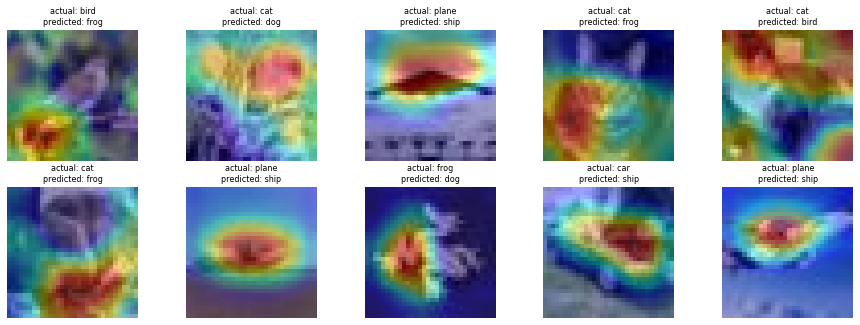

In [43]:
#print(model.named_modules)
def unnorm_img(img):
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  return img

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def gradCAM(model,device,test_loader,num_images):

    model.eval()

    test_failed_data = []
    
    counter = 0

    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)

        
      for k,x in enumerate(pred.eq(target.view_as(pred))):
        
        if not x:
          if num_images <= 0:
            break
          counter = counter+1
          prediction = output[k][pred[k].unsqueeze(dim=1)]
          prediction = prediction.backward(retain_graph=True)
          gradients = model.get_gradient()
          pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
          activations = model.get_activations(data[k].unsqueeze(dim=0)).detach()
          for i in range(512):
            activations[:, i, :, :] *= pooled_gradients[i]
          heatmap = torch.mean(activations.cpu(), dim=1).squeeze()
          heatmap = np.maximum(heatmap, 0)
          heatmap /= torch.max(heatmap)
          heatmap = heatmap.numpy()

          img = unnorm_img(data[k])

          save_image(img,'img.jpg')
          img = cv2.imread('./img.jpg')
          heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
          heatmap = np.uint8(255 * heatmap)
          heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
          superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
          gradcam = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
          tran = transforms.ToTensor()
          plt.subplot(2, 5, counter)
          plt.imshow(gradcam)
          plt.axis('off')
          plt.title("actual: %s\npredicted: %s" % (classes[target[k]], classes [pred[k]]), fontsize=8)
          plt.subplots_adjust(top=3, bottom=2, left=3, right=5)
          num_images = num_images - 1;
      break

gradCAM(model,device,test_loader,num_images)

In [ ]:
im = Image.open('map.jpg')
im.show() 

In [ ]:
# set the evaluation mode
model.eval()
#len(test_10_images)

test_10_images_unnorm = []
for img in test_10_images:
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  test_10_images_unnorm.append(img)

for i in range(1):
  pred = model(test_10_images_unnorm[i].cpu())

  pred.argmax(dim=1)

  pred[:, 2].backward()

  gradients = model.get_gradient()

  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  activations = model.get_activations(test_10_images_unnorm[i]).detach()

  for y in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze()

  heatmap = np.maximum(heatmap, 0)

  heatmap /= torch.max(heatmap)

  plt.matshow(heatmap.squeeze())

  heatmap = heatmap.numpy()

  img = test_10_images_unnorm[i]

  print(img.shape[1])

  break

  save_image(img,'img.jpg')

  img = cv2.imread('./img.jpg')

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  img = torch.from_numpy(superimposed_img)

  

  cv2.imwrite('./map.jpg', superimposed_img)
#save_image(img,'img.jpg')
# interpolate the heatmap
#img = cv2.imread('./img.jpg')
#heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
#heatmap = np.uint8(255 * heatmap)
#heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#superimposed_img = heatmap * 0.4 + img
#cv2.imwrite('./map.jpg', superimposed_img)

In [ ]:
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

In [ ]:
test_10_images_unnorm = []
for img in test_10_images:
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  test_10_images_unnorm.append(img)

grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid, (1,2,0)))
  
